# 1. Import codes and libraries

In [27]:
# import algorithms from .py files
from System import System
from Task import Task
from ApproxTask import ApproxTask

# 2. Simulations and Results

## 1) Simulation Parameters

Simulation parameters for the task set, system and scheduling.

In [28]:
# 1. Task Set Parameters
sys_utils = [0.5, 0.6, 0.7, 0.8, 0.9]
num_sets = 5  # no. task sets to generate with this configuration
n = 200  # no. tasks in set
frame_duration = 500  # length of frame, in ms

precision_taskgen = 2 # decimal places for execution time in taskset generation, i.e. 0.01 = 2 dp
precision_dp = 4  # decimal places for system, i.e. 0.001 = 3 dp
time_step = 1/10**precision_dp  # how responsive the system is, for execution time to be split into time units
lp_hp_ratio = 0.8  # ratio of LP core:HP core speeds

## 2) Generate Task Sets (optional)

This cell will generate a new group of task sets into the 'tasksets/' folder in this directory. **If there is already a group of task sets in the folder, there is no need to run the cell in this section.**

As the tasksets are randomly generated, the obtained results might slightly differ in exact values, but the same trends should be observed.

In [29]:
# import taskset generator algorithm from .py file
from TasksetGenerator import TasksetGenerator

num_lpcores = [1, 2, 3, 4]

# 1. Generate tasksets for system utilisation 50%, 60%, 70%, 80%, 90%, and no. LP cores 1, 2, 3, 4
for sys_util in sys_utils:
    for i in range(num_sets):
        for x in num_lpcores:
            taskset_gen = TasksetGenerator("normal", n, frame_duration, sys_util, precision_taskgen, x, lp_hp_ratio)
            taskset_gen.generate('tasksets/sysutil{0}_cores{1}_{2}.csv'.format(sys_util, x, i))

## 2) Run Simulations

As the simulations are run with the faults occurring randomly, the obtained results might slightly differ in exact values, but the same trends should be observed.

In [30]:
# import CSV reader libraries
from csv import reader
from ast import literal_eval

# import matplotlib for graph plotting
import matplotlib.pyplot as plt

# no. times to run for average
repeat = 5

### a. Energy Consumption vs No. Cores

For a fixed workload, the change in energy consumption vs the number of cores for EnSuRe is observed. The energy consumption for FEST is also shown.

In [31]:
# scheduler parameters
k = 20

# results to collect
energy_consumed_results = []   # get energy consumed from the simulations

# 2. Run algorithms
def run(scheduler_type, num_lpcores):
    sys_util = 0.5
    energy_consumed_per_sysutil = 0
    for i in range(num_sets):
        # i. import task set
        with open('tasksets/sysutil{0}_cores{1}_{2}.csv'.format(sys_util, 1, i)) as read_obj:
            # pass the file object to reader() to get the reader object
            csv_reader = reader(read_obj)
            # Get all rows of csv from csv_reader object as list of tuples
            tasks_data = [tuple(map(literal_eval, x)) for x in map(tuple, csv_reader)]

        # ii. convert data into Task objects
        tasks = []
        for task in tasks_data:
            if scheduler_type == "FEST":
                tasks.append(Task(task[0], task[1], task[2]))
            elif scheduler_type == "EnSuRe":
                tasks.append(ApproxTask(task[0], task[1], task[2], 0, 0, task[3]))

        # iii. run the FEST algorithm
        energy_consumed = 0
        for x in range(repeat):  # repeat several times, due to randomised fault distribution, to get average
            system = System(scheduler_type, k, frame_duration, time_step, num_lpcores, lp_hp_ratio, False)
            system.run(tasks)
            # get total energy consumption
            energy = system.get_energy_consumption()

            energy_consumed += energy
        energy_consumed /= repeat  # get the average from the repeated runs

        # iv. get energy consumption data point from this task set
        energy_consumed_per_sysutil += energy_consumed

    # v. get the average energy consumption for this sys_util value over different task sets
    energy_consumed_per_sysutil /= num_sets
        
    return energy_consumed_per_sysutil

print("Run FEST")
energy_consumed_results.append(run("FEST", 1))
print("Run EnSuRe - 1 LP core")
energy_consumed_results.append(run("EnSuRe", 1))
print("Run EnSuRe - 2 LP cores")
energy_consumed_results.append(run("EnSuRe", 2))
print("Run EnSuRe - 3 LP cores")
energy_consumed_results.append(run("EnSuRe", 3))
print("Run EnSuRe - 4 LP cores")
energy_consumed_results.append(run("EnSuRe", 4))
        
print("Done")
print(energy_consumed_results)

Run FEST
Run EnSuRe - 1 LP core
Run EnSuRe - 2 LP cores
Run EnSuRe - 3 LP cores
Run EnSuRe - 4 LP cores
Done
[154.42672643999987, 159.06058338250008, 169.33259539499997, 179.27468242749995, 189.24976961249996]


In [32]:
# 3. Normalize energy consumption
import numpy as np

# get max energy for normalizing
max_energy = max(energy_consumed_results)

# normalize results
results_norm = np.array(energy_consumed_results) / max_energy

print(results_norm)

[0.81599426 0.84047967 0.89475721 0.94729142 1.        ]


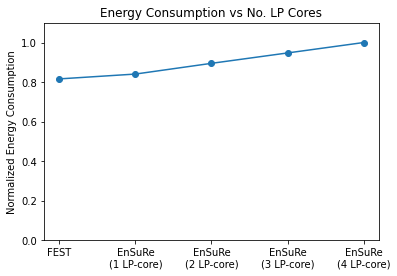

In [33]:
# 4. Plot graph

plt.title('Energy Consumption vs No. LP Cores')
plt.ylabel('Normalized Energy Consumption')

plt.ylim([0.0, 1.1])

x_axis = ['FEST', 'EnSuRe\n(1 LP-core)', 'EnSuRe\n(2 LP-core)', 'EnSuRe\n(3 LP-core)', 'EnSuRe\n(4 LP-core)']

plt.plot(x_axis, results_norm, marker='o')

plt.show()

### b. Energy Consumption vs System Utilisation (%)

System Utilisation is a measure of how much the system is being utilised, as a percentage of the total workload (i.e. execution times) of the tasks over the available time of the LP core(s). The change in energy consumption is observed as system utilisation increases.

In [8]:
# scheduler parameters
k = 20

# results to collect
energy_consumed_results = []   # get energy consumed from the simulations

# 2. Run algorithms
def run(scheduler_type, num_lpcores):
    results = []
    for sys_util in sys_utils:
        energy_consumed_per_sysutil = 0
        for i in range(num_sets):
            # i. import task set
            with open('tasksets/sysutil{0}_cores{1}_{2}.csv'.format(sys_util, num_lpcores, i)) as read_obj:
                # pass the file object to reader() to get the reader object
                csv_reader = reader(read_obj)
                # Get all rows of csv from csv_reader object as list of tuples
                tasks_data = [tuple(map(literal_eval, x)) for x in map(tuple, csv_reader)]

            # ii. convert data into Task objects
            tasks = []
            for task in tasks_data:
                if scheduler_type == "FEST":
                    tasks.append(Task(task[0], task[1], task[2]))
                elif scheduler_type == "EnSuRe":
                    tasks.append(ApproxTask(task[0], task[1], task[2], 0, 0, task[3]))

            # iii. run the FEST algorithm
            energy_consumed = 0
            for x in range(repeat):  # repeat several times, due to randomised fault distribution, to get average
                system = System(scheduler_type, k, frame_duration, time_step, num_lpcores, lp_hp_ratio, False)
                system.run(tasks)
                # get total energy consumption
                energy = system.get_energy_consumption()

                energy_consumed += energy
            energy_consumed /= repeat  # get the average from the repeated runs

            # iv. get energy consumption data point from this task set
            energy_consumed_per_sysutil += energy_consumed

        # v. get the average energy consumption for this sys_util value over different task sets
        energy_consumed_per_sysutil /= num_sets

        results.append(energy_consumed_per_sysutil)
        
    return results

print("Run FEST")
energy_consumed_results.append(run("FEST", 1))
print("Run EnSuRe - 2 LP cores")
energy_consumed_results.append(run("EnSuRe", 2))
print("Run EnSuRe - 3 LP cores")
energy_consumed_results.append(run("EnSuRe", 3))
print("Run EnSuRe - 4 LP cores")
energy_consumed_results.append(run("EnSuRe", 4))
        
print("Done")
print(energy_consumed_results)

Run FEST
Run EnSuRe - 2 LP cores
Run EnSuRe - 3 LP cores
Run EnSuRe - 4 LP cores
Done
[[223.78536503999993, 257.03315555999984, 293.4970729599997, 330.39469367999993, 369.54273695999996], [467.9421158, 528.9771364399999, 612.3964291200002, 647.8335802800004, 726.3225394000001], [686.16142316, 784.58811964, 877.0086011999998, 978.9840526400001, 1065.97457076], [903.8545567599997, 1042.9626965999994, 1150.2338541999998, 1305.1711682399998, 1380.7344832400001]]


In [9]:
# 3. Normalize energy consumption
import numpy as np

# get max energy for normalizing
max_energy = 0
for i in range(len(energy_consumed_results)):
    max_energy = max(max_energy, max(energy_consumed_results[i]))

# normalize results
results_norm = []
for results in energy_consumed_results:
    results_norm.append(np.array(results) / max_energy)

print(results_norm)

[array([0.16207705, 0.18615683, 0.2125659 , 0.23928909, 0.26764214]), array([0.33890811, 0.38311286, 0.44352947, 0.4691949 , 0.5260407 ]), array([0.49695393, 0.56823968, 0.63517542, 0.70903136, 0.77203444]), array([0.65461866, 0.75536804, 0.83305941, 0.9452731 , 1.        ])]


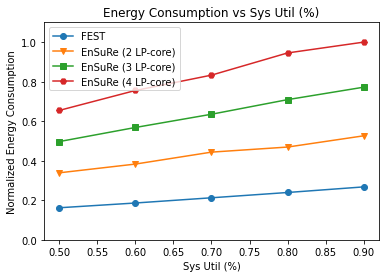

In [10]:
# 4. Plot graph

plt.title('Energy Consumption vs Sys Util (%)')
plt.xlabel('Sys Util (%)')
plt.ylabel('Normalized Energy Consumption')

plt.ylim([0.0, 1.1])

plt.plot(sys_utils, results_norm[0], marker='o', label='FEST')
plt.plot(sys_utils, results_norm[1], marker='v', label='EnSuRe (2 LP-core)')
plt.plot(sys_utils, results_norm[2], marker='s', label='EnSuRe (3 LP-core)')
plt.plot(sys_utils, results_norm[3], marker='H', label='EnSuRe (4 LP-core)')

plt.legend()

plt.show()

### c. Analysing impact of frequency of HP Core

The frequency of the backup core (HP Core) could be set to different scales, which controls how fast the backup core is processing.
The change in frequency affects both the active duration and energy consumption of the backup core.

In [11]:
# scheduler parameters
k = 20
sys_util = 0.5  # fixed at 50% system utilisation
lp_hp_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# results to collect
energy_consumed_results = []   # get energy consumed from the simulations
active_duration_results = []

# 2. Run algorithms
def run(scheduler_type, num_lpcores):
    energy_results = []
    active_results = []
    for spd_ratio in lp_hp_ratios:
        energy_consumed_per_sysutil = 0
        active_duration_per_spdratio = 0
        for i in range(num_sets):
            # i. import task set
            with open('tasksets/sysutil{0}_cores{1}_{2}.csv'.format(sys_util, 1, i)) as read_obj:
                # pass the file object to reader() to get the reader object
                csv_reader = reader(read_obj)
                # Get all rows of csv from csv_reader object as list of tuples
                tasks_data = [tuple(map(literal_eval, x)) for x in map(tuple, csv_reader)]

            # ii. convert data into Task objects
            tasks = []
            for task in tasks_data:
                # Adjust HP core execution time based on new LP:HP speed ratio
                hp_execTime = round(task[1] * spd_ratio, precision_dp)
                if scheduler_type == "FEST":
                    tasks.append(Task(task[0], task[1], hp_execTime))
                elif scheduler_type == "EnSuRe":
                    tasks.append(ApproxTask(task[0], task[1], hp_execTime, 0, 0, task[3]))

            # iii. run the FEST algorithm
            energy_consumed = 0
            active_duration = 0
            for x in range(repeat):  # repeat several times, due to randomised fault distribution, to get average
                system = System(scheduler_type, k, frame_duration, time_step, num_lpcores, spd_ratio)
                system.run(tasks)
                # get total energy consumption
                energy = system.get_energy_consumption()

                # get HP core active duration
                duration = system.get_hpcore_active_duration()

                energy_consumed += energy
                active_duration += duration
            energy_consumed /= repeat  # get the average from the repeated runs
            active_duration /= repeat

            # iv. get energy consumption data point from this task set
            energy_consumed_per_sysutil += energy_consumed
            active_duration_per_spdratio += active_duration

        # v. get the average energy consumption for this sys_util value over different task sets
        energy_consumed_per_sysutil /= num_sets
        active_duration_per_spdratio /= num_sets

        energy_results.append(energy_consumed_per_sysutil)
        active_results.append(active_duration_per_spdratio)
        
    return energy_results, active_results

print("Run FEST")
results = run("FEST", 1)
energy_consumed_results.append(results[0])
active_duration_results.append(results[1])

print("Run EnSuRe - 2 LP cores")
results = run("EnSuRe", 2)
energy_consumed_results.append(results[0])
active_duration_results.append(results[1])

print("Run EnSuRe - 3 LP cores")
results = run("EnSuRe", 3)
energy_consumed_results.append(results[0])
active_duration_results.append(results[1])

print("Run EnSuRe - 4 LP cores")
results = run("EnSuRe", 4)
energy_consumed_results.append(results[0])
active_duration_results.append(results[1])

print("Done")
print(energy_consumed_results)
print(active_duration_results)

Run FEST
Run EnSuRe - 2 LP cores
Run EnSuRe - 3 LP cores
Run EnSuRe - 4 LP cores
Done
[[2924.48853108, 824.5610465999998, 426.5489946711112, 283.17207884, 219.69866723999993, 189.43031134222218, 164.88678003510202, 153.00164095999995, 144.54500612148144, 138.11459595999997], [3704.7699644400004, 1022.7752606399997, 514.1632322785183, 337.84238127999987, 257.39364048, 212.07370250222215, 186.94789173096208, 169.26633200749993, 157.77919684153633, 149.09438028], [3712.67592552, 1033.4293823599996, 515.9577878133333, 349.17056859999985, 266.59322016000004, 222.5340552281481, 195.80404902367349, 179.72163234999994, 167.66638044417013, 158.59350092], [3741.3231722000005, 1044.6396873199997, 531.577317674074, 353.7408148399998, 277.15899244, 233.6428879318518, 206.08474124513123, 189.23388338749996, 177.95372599072704, 169.41512884000002]]
[[2.81612, 5.72864, 8.589, 11.17936, 13.8586, 17.44248, 19.14948, 22.381120000000003, 25.63272, 28.388799999999996], [3.593188, 7.289463999999998, 10.8627

In [12]:
# 3. Normalize energy consumption
import numpy as np

# get max energy for normalizing
max_energy = 0
for i in range(len(energy_consumed_results)):
    max_energy = max(max_energy, max(energy_consumed_results[i]))

# normalize results
results_norm = []
for results in energy_consumed_results:
    results_norm.append(np.array(results) / max_energy)

print(results_norm)

[array([0.78167226, 0.2203929 , 0.1140102 , 0.07568768, 0.05872218,
       0.0506319 , 0.04407178, 0.04089506, 0.03863473, 0.03691598]), array([0.99022987, 0.2733726 , 0.13742818, 0.09030024, 0.06879749,
       0.05668414, 0.04996839, 0.04524237, 0.04217203, 0.03985071]), array([0.99234302, 0.27622029, 0.13790784, 0.0933281 , 0.0712564 ,
       0.05948004, 0.05233551, 0.04803692, 0.04481473, 0.04238968]), array([1.        , 0.27921664, 0.14208271, 0.09454965, 0.07408047,
       0.06244927, 0.05508338, 0.0505794 , 0.04756438, 0.04528214])]


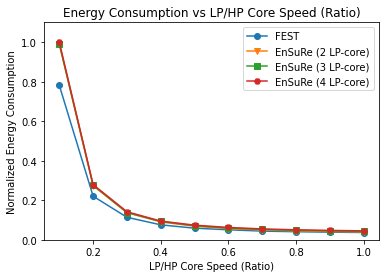

In [13]:
# 4. Plot graph

plt.title('Energy Consumption vs LP/HP Core Speed (Ratio)')
plt.xlabel('LP/HP Core Speed (Ratio)')
plt.ylabel('Normalized Energy Consumption')

plt.ylim([0.0, 1.1])

plt.plot(lp_hp_ratios, results_norm[0], marker='o', label='FEST')
plt.plot(lp_hp_ratios, results_norm[1], marker='v', label='EnSuRe (2 LP-core)')
plt.plot(lp_hp_ratios, results_norm[2], marker='s', label='EnSuRe (3 LP-core)')
plt.plot(lp_hp_ratios, results_norm[3], marker='H', label='EnSuRe (4 LP-core)')

plt.legend()

plt.show()

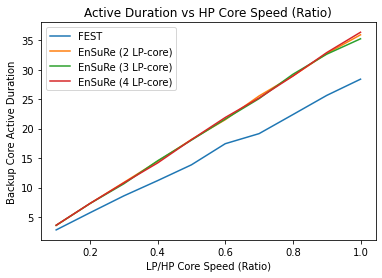

In [14]:
# Plot Backup Core Active Duration vs LP/HP Core Speed

plt.plot(lp_hp_ratios, active_duration_results[0], label='FEST')
plt.plot(lp_hp_ratios, active_duration_results[1], label='EnSuRe (2 LP-core)')
plt.plot(lp_hp_ratios, active_duration_results[2], label='EnSuRe (3 LP-core)')
plt.plot(lp_hp_ratios, active_duration_results[3], label='EnSuRe (4 LP-core)')
plt.title('Active Duration vs HP Core Speed (Ratio)')
plt.xlabel('LP/HP Core Speed (Ratio)')
plt.ylabel('Backup Core Active Duration')

plt.legend()

plt.show()

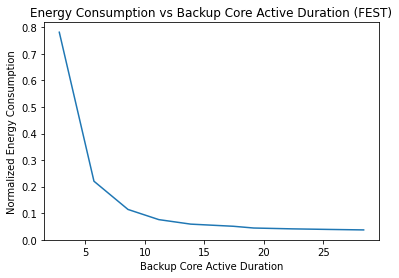

In [15]:
# Plot Energy Consumption vs Backup Core Active Duration

plt.plot(active_duration_results[0], results_norm[0])
plt.title('Energy Consumption vs Backup Core Active Duration (FEST)')
plt.xlabel('Backup Core Active Duration')
plt.ylabel('Normalized Energy Consumption')

plt.show()

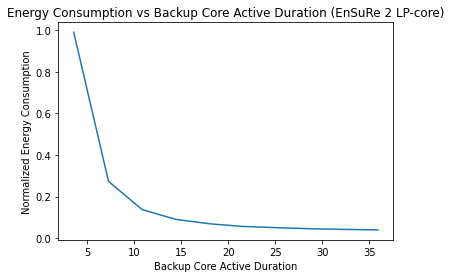

In [16]:
# Plot Energy Consumption vs Backup Core Active Duration

plt.plot(active_duration_results[1], results_norm[1])
plt.title('Energy Consumption vs Backup Core Active Duration (EnSuRe 2 LP-core)')
plt.xlabel('Backup Core Active Duration')
plt.ylabel('Normalized Energy Consumption')

plt.show()

### d. Energy Consumption vs No. Faults, k

When the number of faults increase, more backup tasks will be scheduled on the backup core. Thus, the backup core will consume more power if it is active for a longer duration.

In [24]:
# scheduler parameters
k_values = [20, 40, 60, 80, 100, 120, 140, 160]
sys_util = 0.5  # fixed at 50% system utilisation

# results to collect
energy_consumed_results = []   # get energy consumed from the simulations

# 2. Run algorithms
def run(scheduler_type, num_lpcores):
    results = []
    for k in k_values:
        print("k: {0}".format(k))
        energy_consumed_per_sysutil = 0
        for i in range(num_sets):
            # i. import task set
            with open('tasksets/sysutil{0}_cores{1}_{2}.csv'.format(sys_util, 1, i)) as read_obj:
                # pass the file object to reader() to get the reader object
                csv_reader = reader(read_obj)
                # Get all rows of csv from csv_reader object as list of tuples
                tasks_data = [tuple(map(literal_eval, x)) for x in map(tuple, csv_reader)]

            # ii. convert data into Task objects
            tasks = []
            for task in tasks_data:
                if scheduler_type == "FEST":
                    tasks.append(Task(task[0], task[1], task[2]))
                elif scheduler_type == "EnSuRe":
                    tasks.append(ApproxTask(task[0], task[1], task[2], 0, 0, task[3]))

            # iii. run the FEST algorithm
            energy_consumed = 0
            for x in range(repeat):  # repeat several times, due to randomised fault distribution, to get average
                system = System(scheduler_type, k, frame_duration, time_step, num_lpcores, lp_hp_ratio)
                system.run(tasks)
                # get total energy consumption
                energy = system.get_energy_consumption()

                energy_consumed += energy
            energy_consumed /= repeat  # get the average from the repeated runs

            # iv. get energy consumption data point from this task set
            energy_consumed_per_sysutil += energy_consumed

        # v. get the average energy consumption for this sys_util value over different task sets
        energy_consumed_per_sysutil /= num_sets

        results.append(energy_consumed_per_sysutil)
        
    return results

print("Run FEST")
energy_consumed_results.append(run("FEST", 1))
print("Run EnSuRe - 2 LP cores")
energy_consumed_results.append(run("EnSuRe", 2))
print("Run EnSuRe - 3 LP cores")
energy_consumed_results.append(run("EnSuRe", 3))
print("Run EnSuRe - 4 LP cores")
energy_consumed_results.append(run("EnSuRe", 4))

print("Done")
print(energy_consumed_results)

Run FEST
k: 20
k: 40
k: 60
k: 80
k: 100
k: 120
k: 140
k: 160
Run EnSuRe - 2 LP cores
k: 20
k: 40
k: 60
k: 80
k: 100
k: 120
k: 140
k: 160
Run EnSuRe - 3 LP cores
k: 20
k: 40
k: 60
k: 80
k: 100
k: 120
k: 140
k: 160
Run EnSuRe - 4 LP cores
k: 20
k: 40
k: 60
k: 80
k: 100
k: 120
k: 140
k: 160
Done
[[154.02057547000007, 193.79176229000012, 233.48378812000018, 272.4192683900002, 311.06077632000023, 349.31787921000034, 386.18370319000053, 421.2433899300005], [168.61190476500002, 213.1334432099999, 254.70513199499993, 291.35936755249986, 325.7173308249999, 358.28530130750016, 387.2257837425003, 411.9855264100005], [178.2419411875, 222.74590630499998, 265.0841780774999, 301.25277559999984, 337.2425663849999, 369.7940268300002, 398.11539184250034, 422.8337658300005], [189.1553227025, 232.4773630574999, 274.02435764749987, 312.5601050074999, 347.83556595749997, 380.50490993500017, 409.0196684350003, 432.3083702075005]]


In [25]:
# 3. Normalize energy consumption
import numpy as np

# get max energy for normalizing
max_energy = 0
for i in range(len(energy_consumed_results)):
    max_energy = max(max_energy, max(energy_consumed_results[i]))

# normalize results
results_norm = []
for results in energy_consumed_results:
    results_norm.append(np.array(results) / max_energy)

print(results_norm)

[array([0.35627479, 0.44827206, 0.54008621, 0.63015034, 0.71953448,
       0.80802941, 0.8933061 , 0.97440489]), array([0.39002693, 0.49301253, 0.58917465, 0.67396189, 0.75343748,
       0.82877253, 0.8957166 , 0.95298994]), array([0.41230278, 0.51524773, 0.61318308, 0.69684696, 0.78009724,
       0.85539409, 0.92090605, 0.97808369]), array([0.43754721, 0.53775818, 0.63386318, 0.72300267, 0.80460058,
       0.88017012, 0.94612942, 1.        ])]


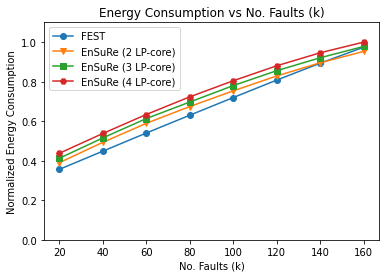

In [26]:
# 4. Plot graph

plt.title('Energy Consumption vs No. Faults (k)')
plt.xlabel('No. Faults (k)')
plt.ylabel('Normalized Energy Consumption')

plt.ylim([0.0, 1.1])

plt.plot(k_values, results_norm[0], marker='o', label='FEST')
plt.plot(k_values, results_norm[1], marker='v', label='EnSuRe (2 LP-core)')
plt.plot(k_values, results_norm[2], marker='s', label='EnSuRe (3 LP-core)')
plt.plot(k_values, results_norm[3], marker='H', label='EnSuRe (4 LP-core)')

plt.legend()

plt.show()